In [2]:
import xarray as xr
fname = '/cw3e/mead/projects/cwp140/data/preprocessed/GEFSv12_reforecast/ivt_final/GEFSv12_reforecast_IVT_20050623.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (number: 5, step: 80, latitude: 281, longitude: 479)
Coordinates:
  * number      (number) int64 40B 0 1 2 3 4
  * step        (step) timedelta64[ns] 640B 0 days 03:00:00 ... 10 days 00:00:00
  * latitude    (latitude) float64 2kB 70.0 69.75 69.5 69.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 4kB -179.5 -179.2 -179.0 ... -60.25 -60.0
    time        datetime64[ns] 8B ...
    valid_time  (step) datetime64[ns] 640B ...
Data variables:
    ivtu        (number, step, latitude, longitude) float64 431MB ...
    ivtv        (number, step, latitude, longitude) float64 431MB ...
    ivt         (number, step, latitude, longitude) float64 431MB ...
Attributes:
    description:  GEFSv12 reforecast IVT fields merged into a single file
    init_date:    20050623

In [4]:
fname = '/cw3e/mead/projects/cwp140/data/preprocessed/GEFSv12_reforecast/ivt_final/GEFSv12_reforecast_IVT_20011118.nc'
ds2 = xr.open_dataset(fname)
ds2

<xarray.Dataset> Size: 1GB
Dimensions:     (number: 5, step: 80, latitude: 281, longitude: 479)
Coordinates:
  * number      (number) int64 40B 0 1 2 3 4
  * step        (step) timedelta64[ns] 640B 0 days 03:00:00 ... 10 days 00:00:00
  * latitude    (latitude) float64 2kB 70.0 69.75 69.5 69.25 ... 0.5 0.25 0.0
  * longitude   (longitude) float64 4kB -179.5 -179.2 -179.0 ... -60.25 -60.0
    time        datetime64[ns] 8B ...
    valid_time  (step) datetime64[ns] 640B ...
Data variables:
    ivtu        (number, step, latitude, longitude) float64 431MB ...
    ivtv        (number, step, latitude, longitude) float64 431MB ...
    ivt         (number, step, latitude, longitude) float64 431MB ...
Attributes:
    description:  GEFSv12 reforecast IVT fields merged into a single file
    init_date:    20011118

In [2]:
## import libraries
import os, sys
import yaml
import xarray as xr
import numpy as np
import pandas as pd
import shutil

path_to_repo = '/home/dnash/repos/SEAK_AR_impacts/'
sys.path.append(path_to_repo+'modules')
import GEFS_funcs as gefs

In [3]:
def calc_prec_rate(ds):
    ## convert precipitation to mm per hour
    ts_3hr = pd.timedelta_range(start='0 day', periods=57, freq='3H')
    ts_6hr = pd.timedelta_range(start='0 day', periods=29, freq='6H')
    tp = ds.tp ## pull out tp
    prec_3hr = tp.sel(step=ts_3hr[1::2]) ## grab only the 3hr values
    tp2 = tp.diff(dim='step') ## calculate difference in precip
    ## the values for 6hr timesteps are correct, the values for 3hr timesteps are incorrect
    prec_6hr = tp2.sel(step=ts_6hr[1:]) # grab only the 6hr values
    new_prec = prec_3hr.combine_first(prec_6hr) # combine the correct 3hr values with the correct 6hr values
    ds = ds.drop_vars(["tp"]) # get rid of old tp (accumulated variable)
    ds = xr.merge([ds, new_prec]) # merge dataset with new tp

    return ds

In [4]:
## dictionary of variables we need
gfs_vardict = {
"u_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"u"}, #U-component of wind
"v_wind":{"typeOfLevel":'isobaricInhPa',"shortName":"v"}, #V-component of wind
"temperature":{"typeOfLevel":'isobaricInhPa',"shortName":"t"}, #Temperature
"rh":{"typeOfLevel":'isobaricInhPa',"shortName":"r"}, #Relative Humidity
"sfc_pressure":{'name': 'Surface pressure', 'typeOfLevel': 'surface', 'level': 0, 'paramId': 134, 'shortName': 'sp'}, #surface pressure
"freezing_level": {'typeOfLevel': 'isothermZero', 'shortName': 'gh'}, ## freezing level 
"prec":{'name': 'Total Precipitation', 'typeOfLevel': 'surface', 'level': 0, 'paramId': 228228, 'shortName': 'tp'} #total precipitation
}
vardict=gfs_vardict["prec"]

In [5]:


ds_lst = []
for i, F in enumerate(np.arange(3, 169, 3)):
    F = str(F).zfill(3)
    fname = '/expanse/lustre/scratch/dnash/temp_project/downloaded/GFS/20240824/gfs.t00z.pgrb2.0p25.f{0}'.format(F)
    dsa = xr.open_dataset(fname, engine='cfgrib',filter_by_keys=vardict)
    dsa = dsa.expand_dims(dim='step')
    ds_lst.append(dsa)

ds1 = xr.concat(ds_lst, dim='step')
## fix lons 
ds1 = ds1.assign_coords({"longitude": (((ds1.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
## subset to N. America [0, 70, 180, 295]
ds1 = ds1.sel(latitude=slice(70, 0), longitude=slice(-179.5, -60.))

ds1 = calc_prec_rate(ds1)
ds1

<xarray.Dataset>
Dimensions:     (step: 56, latitude: 281, longitude: 479)
Coordinates:
    time        datetime64[ns] 2024-08-24
  * step        (step) timedelta64[ns] 0 days 03:00:00 ... 7 days 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 70.0 69.75 69.5 69.25 ... 0.75 0.5 0.25 0.0
    valid_time  (step) datetime64[ns] 2024-08-24T03:00:00 ... 2024-08-31
  * longitude   (longitude) float64 -179.5 -179.2 -179.0 ... -60.5 -60.25 -60.0
Data variables:
    tp          (step, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-25T12:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
config_file = 'config_1.yaml' # this is the config file name
job_info = 'job_281' # this is the job name

config = yaml.load(open(config_file), Loader=yaml.SafeLoader) # read the file
ddict = config[job_info] # pull the job info from the dict

init_date = ddict['init_date']
path_to_data = '/expanse/lustre/scratch/dnash/temp_project/downloaded/GEFS/{0}/'.format(init_date)

ds_lst = []
for i, F in enumerate(np.arange(3, 169, 3)):
    F = str(F).zfill(3)
    fname = path_to_data + 'geavg.t00z.pgrb2a.0p50.f{0}'.format(F)
    dsa = xr.open_dataset(fname, engine='cfgrib',filter_by_keys=vardict)
    dsa = dsa.expand_dims(dim='step')
    ds_lst.append(dsa)

ds = xr.concat(ds_lst, dim='step')

## fix lons 
ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)}) # Convert DataArray longitude coordinates from 0-359 to -180-179
## subset to N. America [0, 70, 180, 295]
ds = ds.sel(latitude=slice(70, 0), longitude=slice(-179.5, -60.))

ds = calc_prec_rate(ds)

ds

<xarray.Dataset>
Dimensions:     (step: 56, latitude: 141, longitude: 240)
Coordinates:
    time        datetime64[ns] 2024-08-24
  * step        (step) timedelta64[ns] 0 days 03:00:00 ... 7 days 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 70.0 69.5 69.0 68.5 68.0 ... 1.5 1.0 0.5 0.0
    valid_time  (step) datetime64[ns] 2024-08-24T03:00:00 ... 2024-08-31
  * longitude   (longitude) float64 -179.5 -179.0 -178.5 ... -61.0 -60.5 -60.0
Data variables:
    tp          (step, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.1
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-25T12:44 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
dsa

<xarray.Dataset>
Dimensions:     (step: 1, latitude: 361, longitude: 720)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 7 days
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude   (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
    valid_time  datetime64[ns] ...
Data variables:
    tp          (step, latitude, longitude) float32 0.1 0.1 0.1 ... 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-25T12:45 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
# Subtract 3 hours from 'step' and 'valid_time' coordinates
dsa = dsa.assign_coords(
    step=dsa.step + np.timedelta64(3, 'h'),
    valid_time=dsa.valid_time + np.timedelta64(3, 'h')
)
dsa

<xarray.Dataset>
Dimensions:     (latitude: 361, longitude: 720, step: 1)
Coordinates:
    time        datetime64[ns] 2024-08-24
    surface     float64 0.0
  * latitude    (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude   (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
    valid_time  datetime64[ns] 2024-08-31T03:00:00
  * step        (step) timedelta64[ns] 7 days 03:00:00
Data variables:
    tp          (step, latitude, longitude) float32 0.1 0.1 0.1 ... 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2025-06-25T12:45 GRIB to CDM+CF via cfgrib-0.9.1...

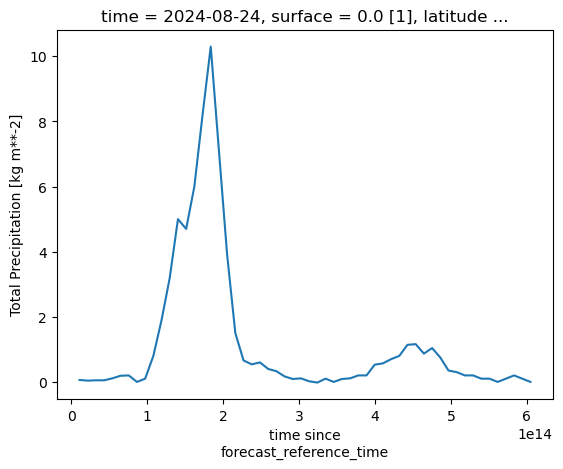

In [6]:
ds.sel(latitude=55, longitude=-132).tp.plot()

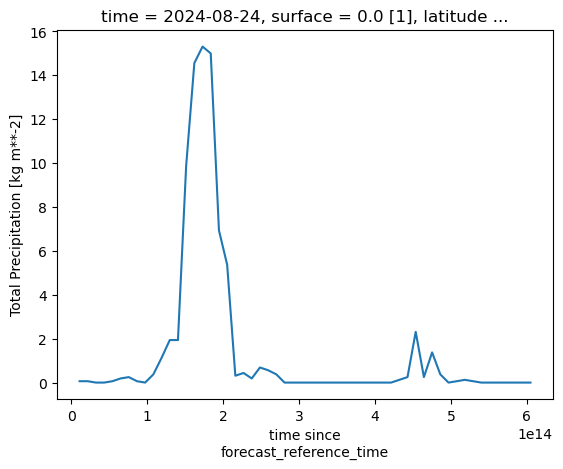

In [7]:
ds1.sel(latitude=55, longitude=-132).tp.plot()